# Predicting Employee Attrition

Installing and Importing Libaries 

In [1]:
#!pip install imbalanced-learn
#!pip install xgboost lightgbm

In [2]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from scipy.stats import spearmanr, kendalltau, pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importing file (csv)

In [3]:
# Import the treated data
df = pd.read_csv('../dados/df.csv')

# Check the data
print(f"Dataset shape: {df.shape}")

Dataset shape: (1470, 32)


In [4]:
print(df.head())

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeNumber  \
0                 1          2  Life Sciences               1   
1                 8          1  Life Sciences               2   
2                 2          2          Other               4   
3                 3          4  Life Sciences               5   
4                 2          1        Medical               7   

   EnvironmentSatisfaction  ... PerformanceRating  RelationshipSatisfaction  \
0                        2  ...                 3                         1   
1     

In [5]:
# Check data types
print(df.dtypes)

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYear        int64
WorkLifeBalance              int64
YearsAtCompany      

## 3. Feature Selection 

Feature Selection Methods Applied:
- **Spearman Correlation**:  Features with correlation > 0.1 AND p-value < 0.05 (numeric features only)
- **Chi-squared Test**: Top 20 most statistically significant categorical features (categorical features only)
- **Mutual Information**: Top 30% highest mutual information scores  
- **ANOVA F-test**: Top 15 most statistically significant numeric features (numeric features only)
- **Mutual Information**: Top 30% highest mutual information scores (all features)
- **Random Forest**: Top 30% most important features from ensemble model (all features)

Selection Criteria:
- Features receive 1 "vote" for each method that selects them
- Final selection: Features with ≥1 vote (selected by at least 1 method)

In [6]:
# 1. Prepare X and y
X = df.drop('Attrition', axis=1)
y = df['Attrition'] 

# Convert target variable from string to numeric
print("Converting target variable from string to numeric...")
y = y.map({'Yes': 1, 'No': 0})
print(f"✅ Target distribution: {y.value_counts()} (1=Yes, 0=No)")

# Convert OverTime from string to binary numeric
print("Converting OverTime from string to numeric...")
X['OverTime'] = X['OverTime'].map({'Yes': 1, 'No': 0})
print(f"  OverTime values: {X['OverTime'].unique()}")

# 2. Create new features
print("\n🆕 Creating new features...")

# Ratio: Years in current role vs years in company
X["YearsInRoleRatio"] = X["YearsInCurrentRole"] / X["YearsAtCompany"].clip(lower=1)

# Relative income vs job level median
joblevel_median_income = X.groupby("JobLevel")["MonthlyIncome"].transform("median")
X["IncomeVsLevelMedian"] = X["MonthlyIncome"] / joblevel_median_income

# Interaction: Overtime × Job Satisfaction
X["Overtime_x_JobSat"] = X["OverTime"] * X["JobSatisfaction"]

print("✅ New features created: YearsInRoleRatio, IncomeVsLevelMedian, Overtime_x_JobSat")

# 3. Feature Groups
# Ordinal features (treat as numeric to preserve order)
ordinal_features = [
    "Education", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel", 
    "JobSatisfaction", "PerformanceRating", "RelationshipSatisfaction", 
    "WorkLifeBalance", "StockOptionLevel"
]

# True categorical features (use one-hot encoding)
categorical_features = [
    "BusinessTravel", "Department", "EducationField", 
    "Gender", "JobRole", "MaritalStatus"
]

# Numeric features (including new features and ordinals)
numeric_features = [
    "Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyIncome",
    "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears",
    "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole",
    "YearsSinceLastPromotion", "YearsWithCurrManager",
    "YearsInRoleRatio", "IncomeVsLevelMedian", "Overtime_x_JobSat"
] + ordinal_features  # Add ordinal features to numeric

binary_features = ["OverTime"]

print(f"\n📊 Feature Categories:")
print(f"• Numerical: {len([f for f in numeric_features if f not in ordinal_features])} regular numeric")
print(f"• Ordinal: {len(ordinal_features)} features (treated as numeric)")
print(f"• Categorical (one-hot): {len(categorical_features)} features") 
print(f"• Binary: {len(binary_features)} features")
print(f"• Total features before encoding: {len(X.columns)}")

# 4. Train-Test Split FIRST
print("\n🎯 Performing train-test split FIRST...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 5. ColumnTransformer - Only one-hot encode true categoricals, pass through ordinals as numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features + binary_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
    ]
)

# Apply preprocessing to training data only
print("\n🔧 Preprocessing training data...")
X_train_encoded = preprocessor.fit_transform(X_train)

# 6. Extract Feature Names
numeric_binary_features = numeric_features + binary_features

# Get one-hot encoded names
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = []
for col, cats in zip(categorical_features, ohe.categories_):
    for cat in cats[1:]:  # drop='first' → skip first category
        ohe_feature_names.append(f"{col}_{cat}")

# Combine all feature names
feature_names = numeric_binary_features + ohe_feature_names

# Create final encoded DataFrame for training
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)

print(f"\n✅ Preprocessing complete!")
print(f"Original features: {len(X_train.columns)}")
print(f"After encoding: {len(X_train_encoded_df.columns)}")
print(f"One-hot features created: {len(ohe_feature_names)}")

# Show sample of one-hot encoded columns
print(f"\n🔍 Sample one-hot encoded columns:")
for col in ohe_feature_names[:5]:
    print(f"  {col}")

# ======================================================
# 7. FEATURE SELECTION ON TRAINING SET ONLY
# ======================================================

print("\n" + "="*60)
print("FEATURE SELECTION - TRAINING SET ONLY")
print("="*60)

# Initialize results table
methods = ['Spearman', 'Chi2', 'MutualInfo', 'RandomForest']  # Removed ANOVA
results_table = pd.DataFrame(index=X_train_encoded_df.columns, columns=methods)
feature_votes = {feature: 0 for feature in X_train_encoded_df.columns}

# Identify feature types for proper method application
numeric_only_features = numeric_features  # All numeric + ordinal features
binary_only_features = binary_features    
categorical_encoded_features = ohe_feature_names  # One-hot encoded features
all_features = X_train_encoded_df.columns.tolist()

# =======================
# METHOD 1: Spearman (numeric features only)
# =======================
print("\n1. Running Spearman correlation (numeric features only)...")
for feature in numeric_only_features:
    try:
        corr, p_value = spearmanr(X_train_encoded_df[feature], y_train)
        if abs(corr) > 0.1 and p_value < 0.05:
            results_table.loc[feature, 'Spearman'] = 'YES'
            feature_votes[feature] += 1
            print(f"  ✓ {feature}: corr={corr:.3f}, p={p_value:.4f}")
        else:
            results_table.loc[feature, 'Spearman'] = 'NO'
            print(f"  ✗ {feature}: corr={corr:.3f}, p={p_value:.4f}")
    except Exception as e:
        results_table.loc[feature, 'Spearman'] = 'ERROR'
        print(f"  ✗ {feature}: {e}")

# Mark non-numeric features as N/A
for feature in all_features:
    if feature not in numeric_only_features:
        results_table.loc[feature, 'Spearman'] = 'N/A'

# =======================
# METHOD 2: Chi-squared (categorical features only)
# =======================
print("\n2. Running Chi-squared tests (categorical features only)...")

# Prepare categorical data for Chi2 (one-hot encoded features)
categorical_data = X_train_encoded_df[categorical_encoded_features]

# Use SelectKBest with chi2 for categorical features with p-value threshold
if len(categorical_encoded_features) > 0:
    # Use p-value threshold instead of fixed k
    selector_chi2 = SelectKBest(chi2, k='all')  # Get all scores first
    selector_chi2.fit(categorical_data, y_train)
    
    # Get chi2 scores and p-values for all features
    chi2_scores = selector_chi2.scores_
    chi2_pvalues = selector_chi2.pvalues_
    
    # Apply p-value threshold
    chi2_selected_features = categorical_data.columns[chi2_pvalues < 0.05].tolist()
    
    # Print detailed results for Chi2
    print(f"  Chi2 Results (p < 0.05):")
    for i, feature in enumerate(categorical_encoded_features):
        score = chi2_scores[i]
        pval = chi2_pvalues[i]
        selected = feature in chi2_selected_features
        status = "✓" if selected else "✗"
        print(f"    {status} {feature}: chi2={score:.2f}, p={pval:.4f}")
    
    # Update results table
    for feature in all_features:
        if feature in categorical_encoded_features:
            if feature in chi2_selected_features:
                results_table.loc[feature, 'Chi2'] = 'YES'
                feature_votes[feature] += 1
            else:
                results_table.loc[feature, 'Chi2'] = 'NO'
        else:
            results_table.loc[feature, 'Chi2'] = 'N/A'
    
    print(f"  Selected {len(chi2_selected_features)} categorical features via Chi2")

# =======================
# METHOD 3: Mutual Information (ALL features)
# =======================
print("\n4. Running Mutual Information (all features)...")
mi_scores = mutual_info_classif(X_train_encoded_df, y_train, random_state=42)
mi_threshold = np.percentile(mi_scores, 70)  # Top 30%

# Print detailed MI results
print(f"  Mutual Information Results (threshold: {mi_threshold:.4f}):")
mi_selected_features = []
for i, feature in enumerate(all_features):
    score = mi_scores[i]
    if score > mi_threshold:
        results_table.loc[feature, 'MutualInfo'] = 'YES'
        feature_votes[feature] += 1
        mi_selected_features.append(feature)
        print(f"    ✓ {feature}: MI={score:.4f}")
    else:
        results_table.loc[feature, 'MutualInfo'] = 'NO'
        print(f"    ✗ {feature}: MI={score:.4f}")

mi_selected_count = len(mi_selected_features)
print(f"  Selected {mi_selected_count} features via Mutual Information")

# =======================
# METHOD 4: Random Forest (ALL features)
# =======================
print("\n5. Running Random Forest (all features)...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_encoded_df, y_train)

rf_threshold = np.percentile(rf.feature_importances_, 70)  # Top 30%

# Print detailed Random Forest results
print(f"  Random Forest Results (threshold: {rf_threshold:.4f}):")
rf_selected_features = []
for i, feature in enumerate(all_features):
    importance = rf.feature_importances_[i]
    if importance > rf_threshold:
        results_table.loc[feature, 'RandomForest'] = 'YES'
        feature_votes[feature] += 1
        rf_selected_features.append(feature)
        print(f"    ✓ {feature}: importance={importance:.4f}")
    else:
        results_table.loc[feature, 'RandomForest'] = 'NO'
        print(f"    ✗ {feature}: importance={importance:.4f}")

rf_selected_count = len(rf_selected_features)
print(f"  Selected {rf_selected_count} features via Random Forest")

# ======================================================
# 8. FINAL RESULTS AND ANALYSIS
# ======================================================

# Add vote count and final decision
def count_valid_votes(row):
    count = 0
    for method in methods:
        if row[method] == 'YES':
            count += 1
    return count

results_table['Votes'] = results_table.apply(count_valid_votes, axis=1)
results_table['Selected'] = results_table['Votes'].apply(lambda x: 'YES' if x >= 2 else 'NO')  # At least 2 methods

print("\n" + "="*100)
print("FEATURE SELECTION RESULTS TABLE (Training Set Only)")
print("="*100)
print(f"{'Feature':<35} {'Spearman':<9} {'Chi2':<5} {'MI':<4} {'RF':<4} {'Votes':<6} {'Selected':<8}")
print("-"*100)

# Show all features but in a more readable format
for feature in results_table.index[:30]:  # Show first 30 features
    row = results_table.loc[feature]
    print(f"{feature:<35} {row['Spearman']:<9} {row['Chi2']:<5} {row['MutualInfo']:<4} {row['RandomForest']:<4} {row['Votes']:<6} {row['Selected']:<8}")

# Summary statistics
selected_count = (results_table['Selected'] == 'YES').sum()
total_features = len(results_table)

print(f"\n📊 SUMMARY")
print(f"Total features: {total_features}")
print(f"Selected features: {selected_count} ({selected_count/total_features*100:.1f}%)")
print(f"Removed features: {total_features - selected_count}")

# Show selected features by category
print(f"\n🎯 SELECTED FEATURES BY CATEGORY:")
selected_features_list = list(results_table[results_table['Selected'] == 'YES'].index)

# Categorize selected features
numeric_selected = [f for f in selected_features_list if f in numeric_only_features]
categorical_selected = [f for f in selected_features_list if f in categorical_encoded_features]
binary_selected = [f for f in selected_features_list if f in binary_only_features]

print(f"  Numerical: {len(numeric_selected)} features")
for feature in numeric_selected:
    votes = results_table.loc[feature, 'Votes']
    print(f"    - {feature} ({votes} votes)")

print(f"  Categorical (one-hot): {len(categorical_selected)} features")
for feature in categorical_selected:  
    votes = results_table.loc[feature, 'Votes']
    print(f"    - {feature} ({votes} votes)")

if binary_selected:
    print(f"  Binary: {len(binary_selected)} features")
    for feature in binary_selected:
        votes = results_table.loc[feature, 'Votes']
        print(f"    - {feature} ({votes} votes)")

# Vote distribution analysis
print(f"\n📈 VOTE DISTRIBUTION:")
vote_distribution = results_table['Votes'].value_counts().sort_index(ascending=False)
for votes, count in vote_distribution.items():
    percentage = (count / total_features) * 100
    print(f"  {votes} votes: {count:2d} features ({percentage:5.1f}%)")

# Method performance analysis
print(f"\n🔧 METHOD PERFORMANCE:")
for method in methods:
    selected_by_method = (results_table[method] == 'YES').sum()
    total_applicable = (results_table[method] != 'N/A').sum()
    if total_applicable > 0:
        percentage = (selected_by_method / total_applicable) * 100
        print(f"  {method}: {selected_by_method:2d}/{total_applicable:2d} features selected ({percentage:5.1f}%)")

# ======================================================
# 9. APPLY SELECTION TO TEST SET
# ======================================================

print("\n🎯 Applying feature selection to test set...")

# Transform test set using the fitted preprocessor
X_test_encoded = preprocessor.transform(X_test)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

# Create reduced datasets
X_train_reduced = X_train_encoded_df[selected_features_list]
X_test_reduced = X_test_encoded_df[selected_features_list]

print(f"✅ FINAL DATASETS:")
print(f"   Training: {X_train_reduced.shape}")
print(f"   Test: {X_test_reduced.shape}")
print(f"   Reduction: {len(X.columns)} → {X_train_reduced.shape[1]} features ({((len(X.columns) - X_train_reduced.shape[1]) / len(X.columns) * 100):.1f}% reduction)")

# Show top features by vote count
print(f"\n🏆 TOP 10 FEATURES BY VOTE COUNT:")
top_features = results_table[results_table['Selected'] == 'YES'].nlargest(10, 'Votes')
for feature, row in top_features.iterrows():
    print(f"  {feature}: {int(row['Votes'])} votes")

# Save the selected feature names for future use
selected_features_final = selected_features_list
print(f"\n💾 Selected features saved for modeling ({len(selected_features_final)} features)")

Converting target variable from string to numeric...
✅ Target distribution: Attrition
0    1233
1     237
Name: count, dtype: int64 (1=Yes, 0=No)
Converting OverTime from string to numeric...
  OverTime values: [1 0]

🆕 Creating new features...
✅ New features created: YearsInRoleRatio, IncomeVsLevelMedian, Overtime_x_JobSat

📊 Feature Categories:
• Numerical: 17 regular numeric
• Ordinal: 9 features (treated as numeric)
• Categorical (one-hot): 6 features
• Binary: 1 features
• Total features before encoding: 34

🎯 Performing train-test split FIRST...
Training set: 1176 samples
Test set: 294 samples

🔧 Preprocessing training data...

✅ Preprocessing complete!
Original features: 34
After encoding: 47
One-hot features created: 20

🔍 Sample one-hot encoded columns:
  BusinessTravel_Travel_Frequently
  BusinessTravel_Travel_Rarely
  Department_Research & Development
  Department_Sales
  EducationField_Life Sciences

FEATURE SELECTION - TRAINING SET ONLY

1. Running Spearman correlation (nu

In [7]:
# Create df_all_data (all features + target)
df_all_data = X_train_encoded_df.copy()
df_all_data['Attrition'] = y_train

# Create df_keep_data (selected features + target)  
df_keep_data = X_train_reduced.copy()
df_keep_data['Attrition'] = y_train

print(f"df_all_data: {df_all_data.shape}")
print(f"df_keep_data: {df_keep_data.shape}")

df_all_data: (1176, 48)
df_keep_data: (1176, 13)


## 4. Predictive Modelling

TARGET VARIABLE DISTRIBUTION:
Attrition = 0 (Stayed): 1233 (83.9%)
Attrition = 1 (Left):   237 (16.1%)


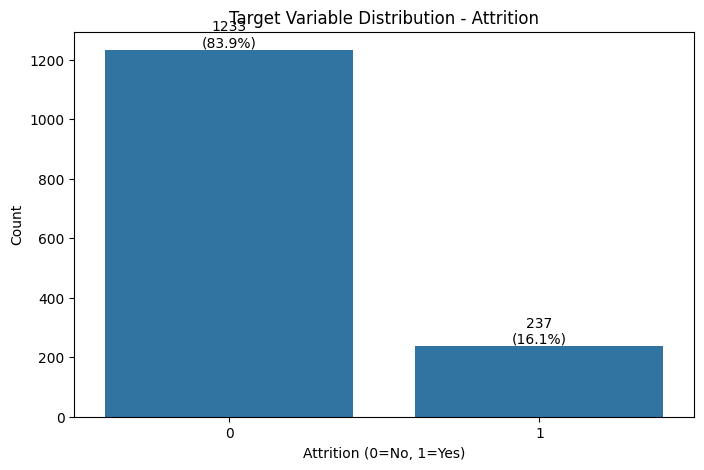

In [8]:
# Check target variable distribution
print("TARGET VARIABLE DISTRIBUTION:")
target_counts = y.value_counts()
target_percent = y.value_counts(normalize=True) * 100

print(f"Attrition = 0 (Stayed): {target_counts[0]} ({target_percent[0]:.1f}%)")
print(f"Attrition = 1 (Left):   {target_counts[1]} ({target_percent[1]:.1f}%)")

plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Target Variable Distribution - Attrition')
plt.xlabel('Attrition (0=No, 1=Yes)')
plt.ylabel('Count')
for i, count in enumerate(target_counts):
    plt.text(i, count + 10, f'{count}\n({target_percent[i]:.1f}%)', ha='center')
plt.show()

In [9]:
# Prepare datasets
df_all_data = X_train_encoded_df.copy()
df_all_data['Attrition'] = y
df_keep_data = X_train_reduced.copy()  
df_keep_data['Attrition'] = y

print("📊 TARGET DISTRIBUTION:")
print(f"Class 0: {(y == 0).sum()} ({((y == 0).sum()/len(y))*100:.1f}%)")
print(f"Class 1: {(y == 1).sum()} ({((y == 1).sum()/len(y))*100:.1f}%)")

📊 TARGET DISTRIBUTION:
Class 0: 1233 (83.9%)
Class 1: 237 (16.1%)


In [10]:
#Define utility functions
def encode_data(dataset):
    """Placeholder for any additional encoding needed"""
    return dataset

def score(y_true, y_pred, set_name="Validation"):
    """Comprehensive scoring function"""
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f'{set_name} - Micro F1: {micro_f1:.3f}, Macro F1: {macro_f1:.3f}, Weighted F1: {weighted_f1:.3f}')
    print(f'{set_name} Classification Report:')
    print(classification_report(y_true=y_true, y_pred=y_pred))
    
    return weighted_f1

In [11]:
#Define model training and evaluation function
def train_and_evaluate_model(data, model, test_size=0.2, val_size=0.25):
    """
    Proper train/validation/test split with cross-validation on training data
    """
    # 1. First split: Separate test set (20%)
    X = data.drop("Attrition", axis=1).copy()
    y = data["Attrition"].copy()
    
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # 2. Second split: Separate validation set from remaining data (25% of remaining = 20% of total)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=42, stratify=y_temp
    )
    
    print(f"📊 DATA SPLITS:")
    print(f"  Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"  Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)") 
    print(f"  Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # Encode data (already done, but for consistency)
    X_train = encode_data(X_train)
    X_val = encode_data(X_val)
    X_test = encode_data(X_test)
    
    # Apply SMOTE to training data only
    print(f"🔄 Applying SMOTE to training data...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print(f"  After SMOTE - Class 0: {(y_train_balanced == 0).sum()}, Class 1: {(y_train_balanced == 1).sum()}")
    
    # Scale the data using training data
    scaler = MinMaxScaler().fit(X_train_balanced)
    X_train_scaled = scaler.transform(X_train_balanced)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Cross-validation on training data
    print(f"🔄 Performing cross-validation...")
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X_train_scaled, y_train_balanced):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train_balanced[train_idx], y_train_balanced[val_idx]
        
        model_cv = model.__class__(**model.get_params())
        model_cv.fit(X_cv_train, y_cv_train)
        y_cv_pred = model_cv.predict(X_cv_val)
        cv_scores.append(f1_score(y_cv_val, y_cv_pred, average='weighted'))
    
    cv_f1 = np.mean(cv_scores)
    print(f"  Cross-validation F1: {cv_f1:.3f} +/- {np.std(cv_scores):.3f}")
    
    # Train final model on full training data
    print(f"🔄 Training final model...")
    model.fit(X_train_scaled, y_train_balanced)
    
    # Predictions on all sets
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_metrics = [
        f1_score(y_train_balanced, y_train_pred, average='weighted'),
        precision_score(y_train_balanced, y_train_pred, average='weighted'),
        recall_score(y_train_balanced, y_train_pred, average='weighted'),
        accuracy_score(y_train_balanced, y_train_pred),
    ]
    
    val_metrics = [
        f1_score(y_val, y_val_pred, average='weighted'),
        precision_score(y_val, y_val_pred, average='weighted'),
        recall_score(y_val, y_val_pred, average='weighted'),
        accuracy_score(y_val, y_val_pred),
    ]
    
    test_metrics = [
        f1_score(y_test, y_test_pred, average='weighted'),
        precision_score(y_test, y_test_pred, average='weighted'),
        recall_score(y_test, y_test_pred, average='weighted'),
        accuracy_score(y_test, y_test_pred),
    ]
    
    # Print results
    print(f"\n📊 FINAL RESULTS for {model.__class__.__name__}:")
    score(y_train_balanced, y_train_pred, "Training")
    score(y_val, y_val_pred, "Validation")
    score(y_test, y_test_pred, "TEST")
    
    return {
        'cv_f1': cv_f1,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'model': model,
        'scaler': scaler,
        'feature_names': X.columns.tolist()
    }

In [12]:
# Define model comparison function
def compare_datasets(models_dict, dataset_name, data):
    """
    Compare models on a specific dataset
    """
    print(f"\n{'='*80}")
    print(f"🔍 TESTING ON {dataset_name.upper()} DATASET")
    print(f"{'='*80}")
    
    results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n🧪 Testing {model_name}...")
        result = train_and_evaluate_model(data, model)
        results[model_name] = result
    
    return results

In [13]:
# Define models
# Define models with proper parameters for imbalanced data
models = {
    'KNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced'),
    'NN': MLPClassifier(max_iter=2000, random_state=42),
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True),
    'RF': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LR': LogisticRegression(C=100, penalty="l2", solver="lbfgs", random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=(y == 0).sum()/(y == 1).sum()),
    'LGBM': LGBMClassifier(random_state=42, class_weight='balanced')
}

print("✅ Models defined successfully!")
print(f"Total models: {len(models)}")
for name, model in models.items():
    print(f"  - {name}: {model.__class__.__name__}")

✅ Models defined successfully!
Total models: 8
  - KNN: KNeighborsClassifier
  - DT: DecisionTreeClassifier
  - NN: MLPClassifier
  - SVM: SVC
  - RF: RandomForestClassifier
  - LR: LogisticRegression
  - XGBoost: XGBClassifier
  - LGBM: LGBMClassifier


In [14]:
# Run experiments on both datasets
print("🚀 COMPREHENSIVE MODEL COMPARISON WITH PROPER TRAIN/VAL/TEST SPLITS")

# Compare both datasets
all_data_results = compare_datasets(models, "ALL FEATURES", df_all_data)
keep_data_results = compare_datasets(models, "SELECTED FEATURES", df_keep_data)

print("✅ Experiments completed!")

🚀 COMPREHENSIVE MODEL COMPARISON WITH PROPER TRAIN/VAL/TEST SPLITS

🔍 TESTING ON ALL FEATURES DATASET

🧪 Testing KNN...
📊 DATA SPLITS:
  Training: 705 samples (59.9%)
  Validation: 235 samples (20.0%)
  Test: 236 samples (20.1%)
🔄 Applying SMOTE to training data...


  After SMOTE - Class 0: 591, Class 1: 591
🔄 Performing cross-validation...
  Cross-validation F1: 0.743 +/- 0.013
🔄 Training final model...

📊 FINAL RESULTS for KNeighborsClassifier:
Training - Micro F1: 0.851, Macro F1: 0.848, Weighted F1: 0.848
Training Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83       591
           1       0.77      0.99      0.87       591

    accuracy                           0.85      1182
   macro avg       0.88      0.85      0.85      1182
weighted avg       0.88      0.85      0.85      1182

Validation - Micro F1: 0.626, Macro F1: 0.556, Weighted F1: 0.675
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       197
           1       0.26      0.71      0.38        38

    accuracy                           0.63       235
   macro avg       0.59      0.66      0.56       235
weighted avg       0.

c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://sciki


📊 FINAL RESULTS for LogisticRegression:
Training - Micro F1: 0.813, Macro F1: 0.813, Weighted F1: 0.813
Training Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       591
           1       0.80      0.83      0.82       591

    accuracy                           0.81      1182
   macro avg       0.81      0.81      0.81      1182
weighted avg       0.81      0.81      0.81      1182

Validation - Micro F1: 0.821, Macro F1: 0.729, Weighted F1: 0.836
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       197
           1       0.47      0.74      0.57        38

    accuracy                           0.82       235
   macro avg       0.70      0.79      0.73       235
weighted avg       0.87      0.82      0.84       235

TEST - Micro F1: 0.763, Macro F1: 0.676, Weighted F1: 0.790
TEST Classification Report:
              precisi

c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 473, number of negative: 473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6225
[LightGBM] [Info] Number of data points in the train set: 946, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 473, number of negative: 473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6208
[Lig

c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 473, number of negative: 473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6230
[LightGBM] [Info] Number of data points in the train set: 946, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Cross-validation F1: 0.919 +/- 0.015
🔄 Training final model...
[LightGBM] [Info] Number of positive: 591, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=tru

c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 FINAL RESULTS for LGBMClassifier:
Training - Micro F1: 1.000, Macro F1: 1.000, Weighted F1: 1.000
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       591

    accuracy                           1.00      1182
   macro avg       1.00      1.00      1.00      1182
weighted avg       1.00      1.00      1.00      1182

Validation - Micro F1: 0.902, Macro F1: 0.763, Weighted F1: 0.886
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       197
           1       0.94      0.42      0.58        38

    accuracy                           0.90       235
   macro avg       0.92      0.71      0.76       235
weighted avg       0.91      0.90      0.89       235

TEST - Micro F1: 0.873, Macro F1: 0.705, Weighted F1: 0.856
TEST Classification Report:
              precision  

c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(



📊 FINAL RESULTS for MLPClassifier:
Training - Micro F1: 0.963, Macro F1: 0.963, Weighted F1: 0.963
Training Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       591
           1       0.96      0.96      0.96       591

    accuracy                           0.96      1182
   macro avg       0.96      0.96      0.96      1182
weighted avg       0.96      0.96      0.96      1182

Validation - Micro F1: 0.783, Macro F1: 0.627, Weighted F1: 0.790
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       197
           1       0.36      0.42      0.39        38

    accuracy                           0.78       235
   macro avg       0.62      0.64      0.63       235
weighted avg       0.80      0.78      0.79       235

TEST - Micro F1: 0.771, Macro F1: 0.609, Weighted F1: 0.780
TEST Classification Report:
              precision   

c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 473, number of negative: 472
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2187
[LightGBM] [Info] Number of data points in the train set: 945, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 473, number of negative: 473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2197
[LightGBM] [Info] Number of data points in the train set: 946, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 473, number of negative: 473
[LightGBM] [In

c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [15]:
# Create summary table and visualization
# Create summary table
print(f"\n{'='*100}")
print(f"📊 FINAL COMPARISON SUMMARY")
print(f"{'='*100}")

summary_df = pd.DataFrame(
    columns=[
        "Dataset", "Model", "CV F1", "Train F1", "Val F1", "TEST F1", 
        "Test Precision", "Test Recall", "Test Accuracy"
    ]
)

row_idx = 0
for dataset_name, results in [("All Features", all_data_results), ("Selected Features", keep_data_results)]:
    for model_name, result in results.items():
        summary_df.loc[row_idx] = [
            dataset_name,
            model_name,
            f"{result['cv_f1']:.3f}",
            f"{result['train_metrics'][0]:.3f}",
            f"{result['val_metrics'][0]:.3f}",
            f"{result['test_metrics'][0]:.3f}",
            f"{result['test_metrics'][1]:.3f}",
            f"{result['test_metrics'][2]:.3f}",
            f"{result['test_metrics'][3]:.3f}"
        ]
        row_idx += 1

print(summary_df.to_string(index=False))


📊 FINAL COMPARISON SUMMARY
          Dataset   Model CV F1 Train F1 Val F1 TEST F1 Test Precision Test Recall Test Accuracy
     All Features     KNN 0.743    0.848  0.675   0.727          0.830       0.686         0.686
     All Features      DT 0.775    0.805  0.776   0.778          0.793       0.767         0.767
     All Features      NN 0.942    1.000  0.841   0.881          0.878       0.886         0.886
     All Features     SVM 0.917    0.971  0.862   0.849          0.847       0.864         0.864
     All Features      RF 0.932    1.000  0.870   0.874          0.898       0.894         0.894
     All Features      LR 0.793    0.813  0.836   0.790          0.853       0.763         0.763
     All Features XGBoost 0.919    1.000  0.884   0.854          0.851       0.860         0.860
     All Features    LGBM 0.919    1.000  0.886   0.856          0.858       0.873         0.873
Selected Features     KNN 0.797    0.889  0.740   0.745          0.795       0.716         0.716
Se

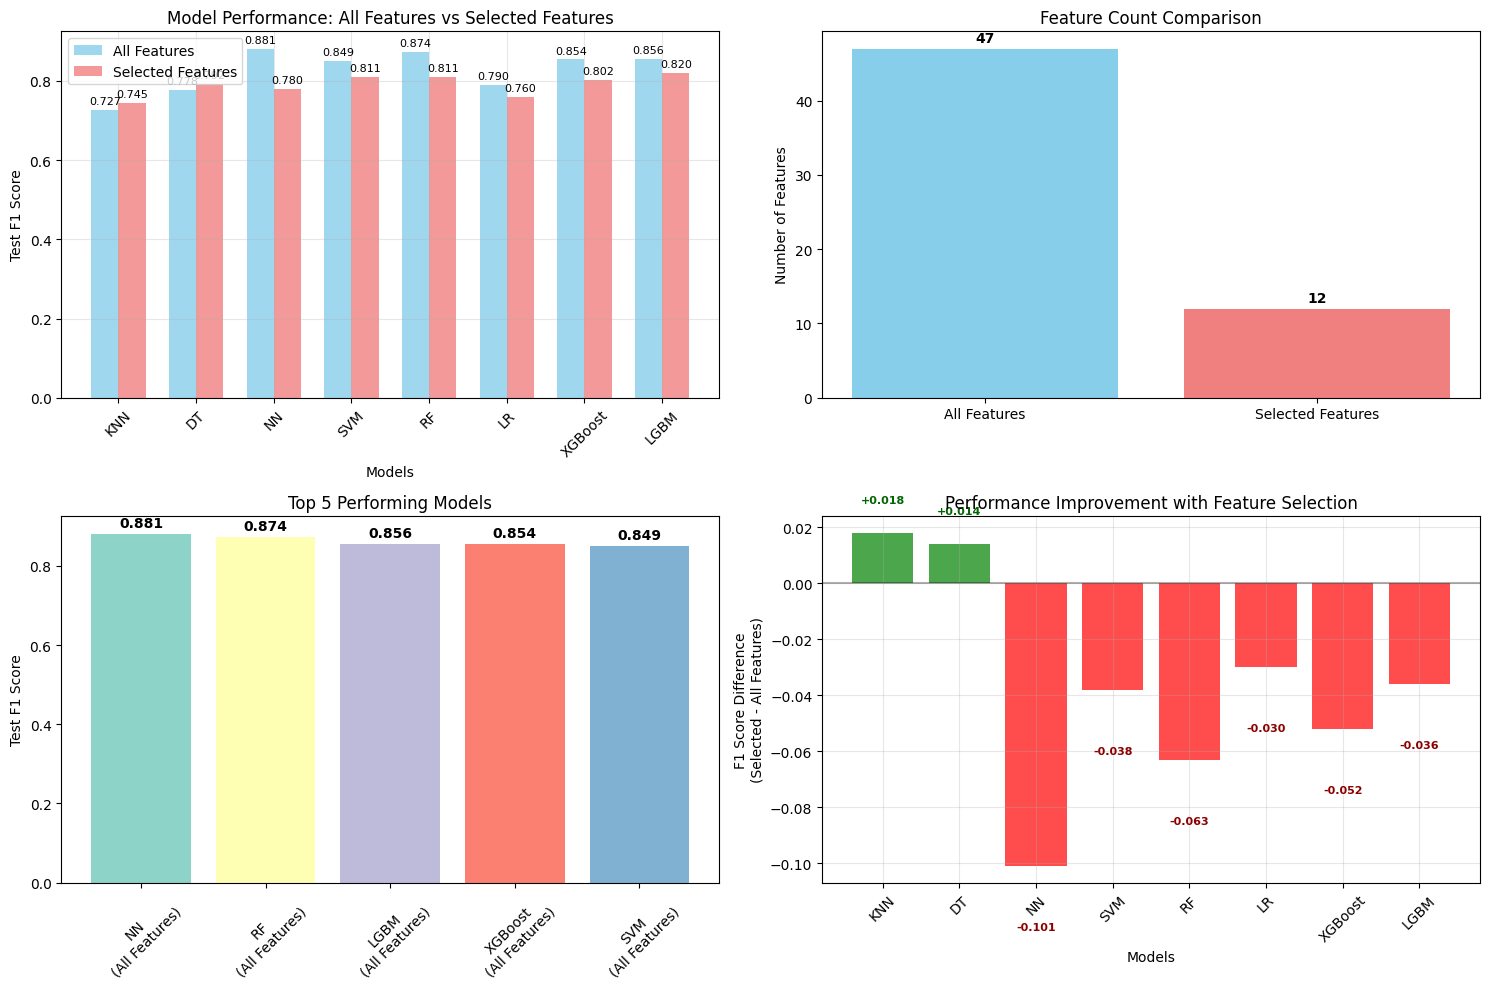

✅ Visualizations created successfully!

📊 PERFORMANCE SUMMARY:
Models improved with feature selection: 2/8 (25.0%)
Average F1 score difference: -0.036
⚠️ All features dataset performed slightly better on average


In [16]:
# Visualization - Model Performance Comparison
# Create visualization comparing model performance
plt.figure(figsize=(15, 10))

# Convert string columns to numeric for proper sorting and comparison
summary_df_numeric = summary_df.copy()
numeric_columns = ['CV F1', 'Train F1', 'Val F1', 'TEST F1', 'Test Precision', 'Test Recall', 'Test Accuracy']
for col in numeric_columns:
    summary_df_numeric[col] = pd.to_numeric(summary_df_numeric[col], errors='coerce')

# Extract test F1 scores for visualization
all_features_test_f1 = []
selected_features_test_f1 = []
model_names = list(models.keys())

for model_name in model_names:
    all_f1 = summary_df_numeric[(summary_df_numeric['Dataset'] == 'All Features') & 
                               (summary_df_numeric['Model'] == model_name)]['TEST F1'].values[0]
    selected_f1 = summary_df_numeric[(summary_df_numeric['Dataset'] == 'Selected Features') & 
                                    (summary_df_numeric['Model'] == model_name)]['TEST F1'].values[0]
    
    all_features_test_f1.append(all_f1)
    selected_features_test_f1.append(selected_f1)

# Plot 1: Model Performance Comparison
plt.subplot(2, 2, 1)
x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, all_features_test_f1, width, label='All Features', alpha=0.8, color='skyblue')
plt.bar(x + width/2, selected_features_test_f1, width, label='Selected Features', alpha=0.8, color='lightcoral')
plt.xlabel('Models')
plt.ylabel('Test F1 Score')
plt.title('Model Performance: All Features vs Selected Features')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(all_features_test_f1):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(selected_features_test_f1):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Feature Count Comparison
plt.subplot(2, 2, 2)
feature_counts = [df_all_data.shape[1] - 1, df_keep_data.shape[1] - 1]  # -1 for target
colors = ['skyblue', 'lightcoral']
plt.bar(['All Features', 'Selected Features'], feature_counts, color=colors)
plt.ylabel('Number of Features')
plt.title('Feature Count Comparison')
for i, v in enumerate(feature_counts):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# Plot 3: Best Performing Models
plt.subplot(2, 2, 3)
best_models = summary_df_numeric.nlargest(5, 'TEST F1')[['Model', 'Dataset', 'TEST F1']]
plt.bar(range(len(best_models)), best_models['TEST F1'], 
        color=plt.cm.Set3(range(len(best_models))))
plt.xticks(range(len(best_models)), [f"{row.Model}\n({row.Dataset})" for _, row in best_models.iterrows()], rotation=45)
plt.ylabel('Test F1 Score')
plt.title('Top 5 Performing Models')

# Add value labels on top of bars
for i, v in enumerate(best_models['TEST F1']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Performance Difference (Selected - All Features)
plt.subplot(2, 2, 4)
performance_diff = []
for model_name in model_names:
    all_f1 = summary_df_numeric[(summary_df_numeric['Dataset'] == 'All Features') & 
                               (summary_df_numeric['Model'] == model_name)]['TEST F1'].values[0]
    selected_f1 = summary_df_numeric[(summary_df_numeric['Dataset'] == 'Selected Features') & 
                                    (summary_df_numeric['Model'] == model_name)]['TEST F1'].values[0]
    performance_diff.append(selected_f1 - all_f1)

colors = ['green' if diff > 0 else 'red' for diff in performance_diff]
plt.bar(model_names, performance_diff, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Models')
plt.ylabel('F1 Score Difference\n(Selected - All Features)')
plt.title('Performance Improvement with Feature Selection')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(performance_diff):
    plt.text(i, v + (0.01 if v >= 0 else -0.02), f'{v:+.3f}', 
             ha='center', va='bottom' if v >= 0 else 'top', fontsize=8,
             fontweight='bold', color='darkgreen' if v >= 0 else 'darkred')

plt.tight_layout()
plt.show()

print("✅ Visualizations created successfully!")

# Print performance summary
print(f"\n📊 PERFORMANCE SUMMARY:")
improved_models = sum(1 for diff in performance_diff if diff > 0)
total_models = len(performance_diff)
print(f"Models improved with feature selection: {improved_models}/{total_models} ({improved_models/total_models*100:.1f}%)")

avg_performance_diff = np.mean(performance_diff)
print(f"Average F1 score difference: {avg_performance_diff:+.3f}")

if avg_performance_diff > 0:
    print("🎉 Feature selection improved overall model performance!")
else:
    print("⚠️ All features dataset performed slightly better on average")

In [17]:
# Final insights and recommendations
print(f"\n{'='*80}")
print(f"🎯 KEY INSIGHTS AND RECOMMENDATIONS")
print(f"{'='*80}")

# Find best model overall
best_overall = summary_df.loc[summary_df['TEST F1'].astype(float).idxmax()]
print(f"🏆 BEST OVERALL MODEL: {best_overall['Model']} on {best_overall['Dataset']}")
print(f"   Test F1 Score: {best_overall['TEST F1']}")

# Compare feature set performance
all_features_avg = summary_df[summary_df['Dataset'] == 'All Features']['TEST F1'].astype(float).mean()
selected_features_avg = summary_df[summary_df['Dataset'] == 'Selected Features']['TEST F1'].astype(float).mean()

print(f"\n📈 DATASET COMPARISON:")
print(f"   Average Test F1 - All Features: {all_features_avg:.3f}")
print(f"   Average Test F1 - Selected Features: {selected_features_avg:.3f}")
print(f"   Feature Reduction: {df_all_data.shape[1]-1} → {df_keep_data.shape[1]-1} ({(1-df_keep_data.shape[1]/df_all_data.shape[1])*100:.1f}% reduction)")

if selected_features_avg > all_features_avg:
    print("   ✅ Selected features dataset performs better on average!")
else:
    print("   ⚠️ All features dataset performs slightly better, but selected features offer simplicity")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   1. Use {best_overall['Model']} with {best_overall['Dataset']} for production")
print(f"   2. Consider feature importance for model interpretability")
print(f"   3. Monitor model performance on new data regularly")


🎯 KEY INSIGHTS AND RECOMMENDATIONS
🏆 BEST OVERALL MODEL: NN on All Features
   Test F1 Score: 0.881

📈 DATASET COMPARISON:
   Average Test F1 - All Features: 0.826
   Average Test F1 - Selected Features: 0.790
   Feature Reduction: 47 → 12 (72.9% reduction)
   ⚠️ All features dataset performs slightly better, but selected features offer simplicity

💡 RECOMMENDATIONS:
   1. Use NN with All Features for production
   2. Consider feature importance for model interpretability
   3. Monitor model performance on new data regularly
